In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import psutil

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Dec  1 04:27:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             30W /   70W |    1286MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
# =============================================================
# DCRNN TRAINING PIPELINE (NO DRIVE — USE UPLOADED FILES)
# =============================================================

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================================================
# USER CONFIG
# =============================================================
SEQ_LEN  = 12
PRED_LEN = 3
BATCH_SIZE = 64
HIDDEN_DIM = 64
EPOCHS = 20
LR = 0.001
DROPOUT = 0.2

DATA_FOLDER = "/content/drive/MyDrive/CIS-583 Deep Learning/CIS-583 Deep Learning: The Fourcast Quarter/Assets/Datasets/PEMS-BAY/Raw Dataset"
DATA_PATH = DATA_FOLDER + "/PEMS-BAY.csv"


Using device: cuda


In [15]:
# =============================
# CORRECT LOAD SPEED DATA
# =============================
speed_df = pd.read_csv(
    DATA_PATH,
    index_col=0,             # first column is timestamp
    parse_dates=True         # convert timestamp to datetime
)

print("Raw CSV shape:", speed_df.shape)
print("Index example:", speed_df.index[0])

# Convert to float32 numpy (52116 × 325)
data_all = speed_df.values.astype(np.float32)

T, N = data_all.shape
print("Total Timesteps:", T, "Sensors:", N)


Raw CSV shape: (52116, 325)
Index example: 2017-01-01 00:00:00
Total Timesteps: 52116 Sensors: 325


In [16]:
# =============================
# TIME SPLIT
# =============================
num_train = int(0.7 * T)
num_val   = int(0.2 * T)
num_test  = T - num_train - num_val

train_raw = data_all[:num_train]
val_raw   = data_all[num_train:num_train+num_val]
test_raw  = data_all[num_train+num_val:]

print("Train:", train_raw.shape)
print("Val:  ", val_raw.shape)
print("Test: ", test_raw.shape)


Train: (36481, 325)
Val:   (10423, 325)
Test:  (5212, 325)


In [17]:
# =============================
# NORMALIZATION
# =============================
train_mean = train_raw.mean(axis=0)
train_std  = train_raw.std(axis=0)

def normalize(x):
    return (x - train_mean) / (train_std + 1e-8)

def denormalize(x):
    return x * (train_std + 1e-8) + train_mean

train_norm = normalize(train_raw)
val_norm   = normalize(val_raw)
test_norm  = normalize(test_raw)


In [18]:
# =============================
# BUILD SEQUENCES
# =============================
def create_sequences(data, seq_len, pred_len):
    X, Y = [], []
    T = data.shape[0]

    for i in range(T - seq_len - pred_len):
        X.append(data[i:i+seq_len, :, None])
        Y.append(data[i+seq_len:i+seq_len+pred_len, :, None])

    return np.array(X), np.array(Y)

X_train, Y_train = create_sequences(train_norm, SEQ_LEN, PRED_LEN)
X_val,   Y_val   = create_sequences(val_norm,   SEQ_LEN, PRED_LEN)
X_test,  Y_test  = create_sequences(test_norm,  SEQ_LEN, PRED_LEN)

print("Train sequences:", X_train.shape, Y_train.shape)
print("Val sequences:  ", X_val.shape,   Y_val.shape)
print("Test sequences: ", X_test.shape,  Y_test.shape)


Train sequences: (36466, 12, 325, 1) (36466, 3, 325, 1)
Val sequences:   (10408, 12, 325, 1) (10408, 3, 325, 1)
Test sequences:  (5197, 12, 325, 1) (5197, 3, 325, 1)


In [19]:
# =============================
# DATA LOADERS
# =============================
train_loader = DataLoader(TensorDataset(
    torch.FloatTensor(X_train), torch.FloatTensor(Y_train)),
    batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(TensorDataset(
    torch.FloatTensor(X_val), torch.FloatTensor(Y_val)),
    batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(TensorDataset(
    torch.FloatTensor(X_test), torch.FloatTensor(Y_test)),
    batch_size=BATCH_SIZE, shuffle=False)


In [20]:
# =============================
# MODEL COMPONENTS
# =============================
class DiffusionConv(nn.Module):
    def __init__(self, num_nodes, F_in, F_out, dropout):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(F_in, F_out))
        nn.init.xavier_uniform_(self.theta)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj):
        diff = torch.einsum("ij,bjf->bif", adj, x)
        return self.dropout(torch.einsum("bif,fo->bio", diff, self.theta))


class DCRNNCell(nn.Module):
    def __init__(self, num_nodes, hidden_dim, dropout):
        super().__init__()
        self.diff = DiffusionConv(num_nodes, 1 + hidden_dim, hidden_dim, dropout)
        self.gru  = nn.GRUCell(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_t, h_prev, adj):
        combined = torch.cat([x_t, h_prev], dim=-1)
        conv = self.diff(combined, adj)

        B, N, H = conv.shape
        conv = conv.reshape(B*N, H)
        h_prev = h_prev.reshape(B*N, H)

        h = self.gru(conv, h_prev).reshape(B, N, H)
        return self.dropout(h)


In [21]:
class DCRNN(nn.Module):
    def __init__(self, num_nodes, hidden_dim, pred_len, dropout):
        super().__init__()
        self.cell = DCRNNCell(num_nodes, hidden_dim, dropout)
        self.fc_out = nn.Linear(hidden_dim, pred_len)

        # Learnable adjacency (very simplified)
        self.adj = nn.Parameter(torch.eye(num_nodes), requires_grad=True)

    def forward(self, x):
        B, T, N, _ = x.shape
        h = torch.zeros(B, N, HIDDEN_DIM, device=x.device)

        for t in range(T):
            h = self.cell(x[:, t], h, self.adj)

        out = self.fc_out(h)      # [B, N, 12]
        return out.permute(0, 2, 1).unsqueeze(-1)


DCRNN(
  (cell): DCRNNCell(
    (diff): DiffusionConv(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (gru): GRUCell(64, 64)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=64, out_features=3, bias=True)
)
🔥 New best model saved!
Epoch 1/20 | Train=0.135091 | Val=0.125656
🔥 New best model saved!
Epoch 2/20 | Train=0.095912 | Val=0.116318
🔥 New best model saved!
Epoch 3/20 | Train=0.092668 | Val=0.113166
🔥 New best model saved!
Epoch 4/20 | Train=0.090913 | Val=0.110939
🔥 New best model saved!
Epoch 5/20 | Train=0.090029 | Val=0.109695
🔥 New best model saved!
Epoch 6/20 | Train=0.089424 | Val=0.109023
🔥 New best model saved!
Epoch 7/20 | Train=0.088611 | Val=0.107605
🔥 New best model saved!
Epoch 8/20 | Train=0.088356 | Val=0.106922
Epoch 9/20 | Train=0.087915 | Val=0.107029
🔥 New best model saved!
Epoch 10/20 | Train=0.087630 | Val=0.105947
🔥 New best model saved!
Epoch 11/20 | Train=0.087402 | Val=0.105902
🔥 New best model saved!
Epoch 12/20 |

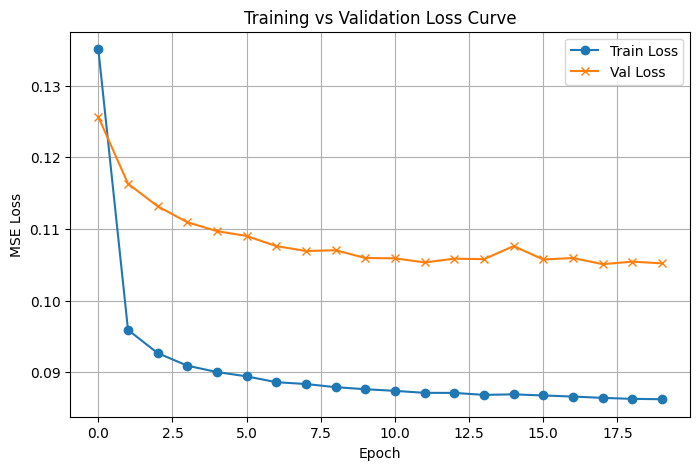

In [22]:
model = DCRNN(N, HIDDEN_DIM, PRED_LEN, DROPOUT).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

print(model)

best_val = float("inf")

# Lists to store epoch-level losses
train_curve = []
val_curve   = []

# =============================
# TRAINING
# =============================
for epoch in range(1, EPOCHS + 1):
    model.train()
    batch_train_losses = []

    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)

        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    # ---- Validation ----
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            preds = model(Xb)
            batch_val_losses.append(criterion(preds, Yb).item())

    # Compute mean losses for this epoch
    avg_train = np.mean(batch_train_losses)
    avg_val   = np.mean(batch_val_losses)

    train_curve.append(avg_train)
    val_curve.append(avg_val)

    # Save best model
    if avg_val < best_val:
        best_val = avg_val
        torch.save(model.state_dict(), "dcrnn_best.pt")
        print("🔥 New best model saved!")

    print(f"Epoch {epoch}/{EPOCHS} | Train={avg_train:.6f} | Val={avg_val:.6f}")

print("Training complete! Best Val Loss:", best_val)

# =============================
# PLOT LOSS CURVE
# =============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_curve, label="Train Loss", marker='o')
plt.plot(val_curve, label="Val Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss Curve")
plt.grid(True)
plt.legend()

plt.savefig("loss_curve.png", dpi=200)
plt.show()


In [23]:
# Test metrics: MSE + MAE/RMSE in original units (1-step ahead)

from math import sqrt

def evaluate_mse(loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

model.load_state_dict(torch.load("dcrnn_best.pt", map_location=device))
model.eval()

# 1) normalized MSE on test set
test_mse_norm = evaluate_mse(test_loader)
print("Test MSE (normalized):", test_mse_norm)

# 2) MAE and RMSE in original speed units
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        preds = model(X_batch)
        preds = preds.cpu().numpy()
        targets = Y_batch.cpu().numpy()

        preds = preds.squeeze(-1)
        targets = targets.squeeze(-1)

        all_preds.append(preds.reshape(-1, N))
        all_targets.append(targets.reshape(-1, N))

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# denormalize
all_preds_denorm   = denormalize(all_preds)
all_targets_denorm = denormalize(all_targets)

mae = np.mean(np.abs(all_preds_denorm - all_targets_denorm))
rmse = sqrt(np.mean((all_preds_denorm - all_targets_denorm) ** 2))

print(f"Test MAE (original units):  {mae:.4f}")
print(f"Test RMSE (original units): {rmse:.4f}")

Test MSE (normalized): 0.13224592379837144
Test MAE (original units):  1.3320
Test RMSE (original units): 2.5764


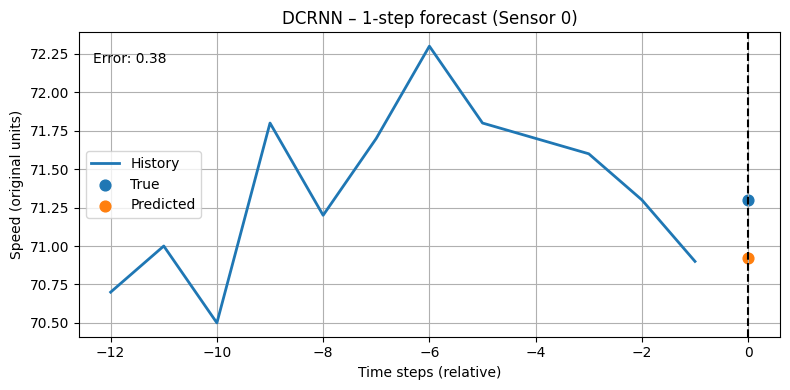

In [24]:
# 13. Visualize one forecast vs ground truth for a chosen sensor

sensor_index = 0   # change this

# Use last test window
example_idx = X_test.shape[0] - 1
X_example = X_test[example_idx:example_idx+1]
Y_example = Y_test[example_idx:example_idx+1]

model.eval()
with torch.no_grad():
    X_torch = torch.from_numpy(X_example).float().to(device)
    pred_full = model(X_torch).cpu().numpy()

history_norm     = X_example[0, :, sensor_index, 0]
true_future_norm = Y_example[0, 0, sensor_index, 0]
pred_future_norm = pred_full[0, 0, sensor_index, 0]

# Per-sensor stats
mean = float(train_mean[sensor_index])
std  = float(train_std[sensor_index])

# Denormalize
history     = history_norm * (std + 1e-8) + mean
true_future = true_future_norm * (std + 1e-8) + mean
pred_future = pred_future_norm * (std + 1e-8) + mean

# x-axis
hist_x = list(range(-len(history), 0))
future_x = [0]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(hist_x, history, label="History", linewidth=2)
ax.scatter(future_x, [true_future], label="True", s=60)
ax.scatter(future_x, [pred_future], label="Predicted", s=60)

ax.axvline(0, color="k", linestyle="--")
ax.set_xlabel("Time steps (relative)")
ax.set_ylabel("Speed (original units)")
ax.set_title(f"DCRNN – 1-step forecast (Sensor {sensor_index})")
ax.grid(True)

err = float(abs(true_future - pred_future))
ax.text(0.02, 0.9, f"Error: {err:.2f}", transform=ax.transAxes)

ax.legend()
plt.tight_layout()
plt.show()

mae_per_sensor shape: (325,)


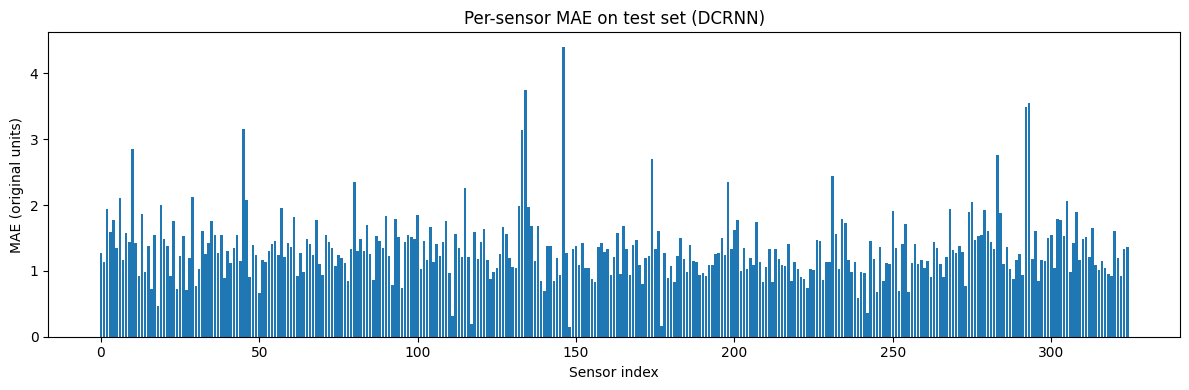

In [25]:
# 14. Per-sensor MAE bar plot
# Quickly show which sensors are hardest to predict (higher bar = worse MAE).

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        preds = model(X_batch)          # [B, PRED_LEN, N, 1]
        preds = preds.cpu().numpy()
        targets = Y_batch.cpu().numpy()

        # Remove last (feature) dim → [B, PRED_LEN, N]
        preds = preds.squeeze(-1)
        targets = targets.squeeze(-1)

        # Flatten batch and time into one axis → [B * PRED_LEN, N]
        B, P, N_sensors = preds.shape
        preds = preds.reshape(-1, N_sensors)
        targets = targets.reshape(-1, N_sensors)

        all_preds.append(preds)
        all_targets.append(targets)

# Stack over batches → [T_flat, N]
all_preds = np.concatenate(all_preds, axis=0)      # normalized
all_targets = np.concatenate(all_targets, axis=0)  # normalized

# Denormalize to original units
all_preds_denorm   = denormalize(all_preds)
all_targets_denorm = denormalize(all_targets)

# Absolute error: [T_flat, N]
abs_errors = np.abs(all_preds_denorm - all_targets_denorm)

# Per-sensor MAE: [N]
mae_per_sensor = abs_errors.mean(axis=0)

print("mae_per_sensor shape:", mae_per_sensor.shape)  # should be (N,)

plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(mae_per_sensor)), mae_per_sensor)
plt.xlabel("Sensor index")
plt.ylabel("MAE (original units)")
plt.title("Per-sensor MAE on test set (DCRNN)")
plt.tight_layout()
plt.show()


Best sensors: [148 177 117]
Worst sensors: [293 134 146]
Random sensors: [259 208 306]


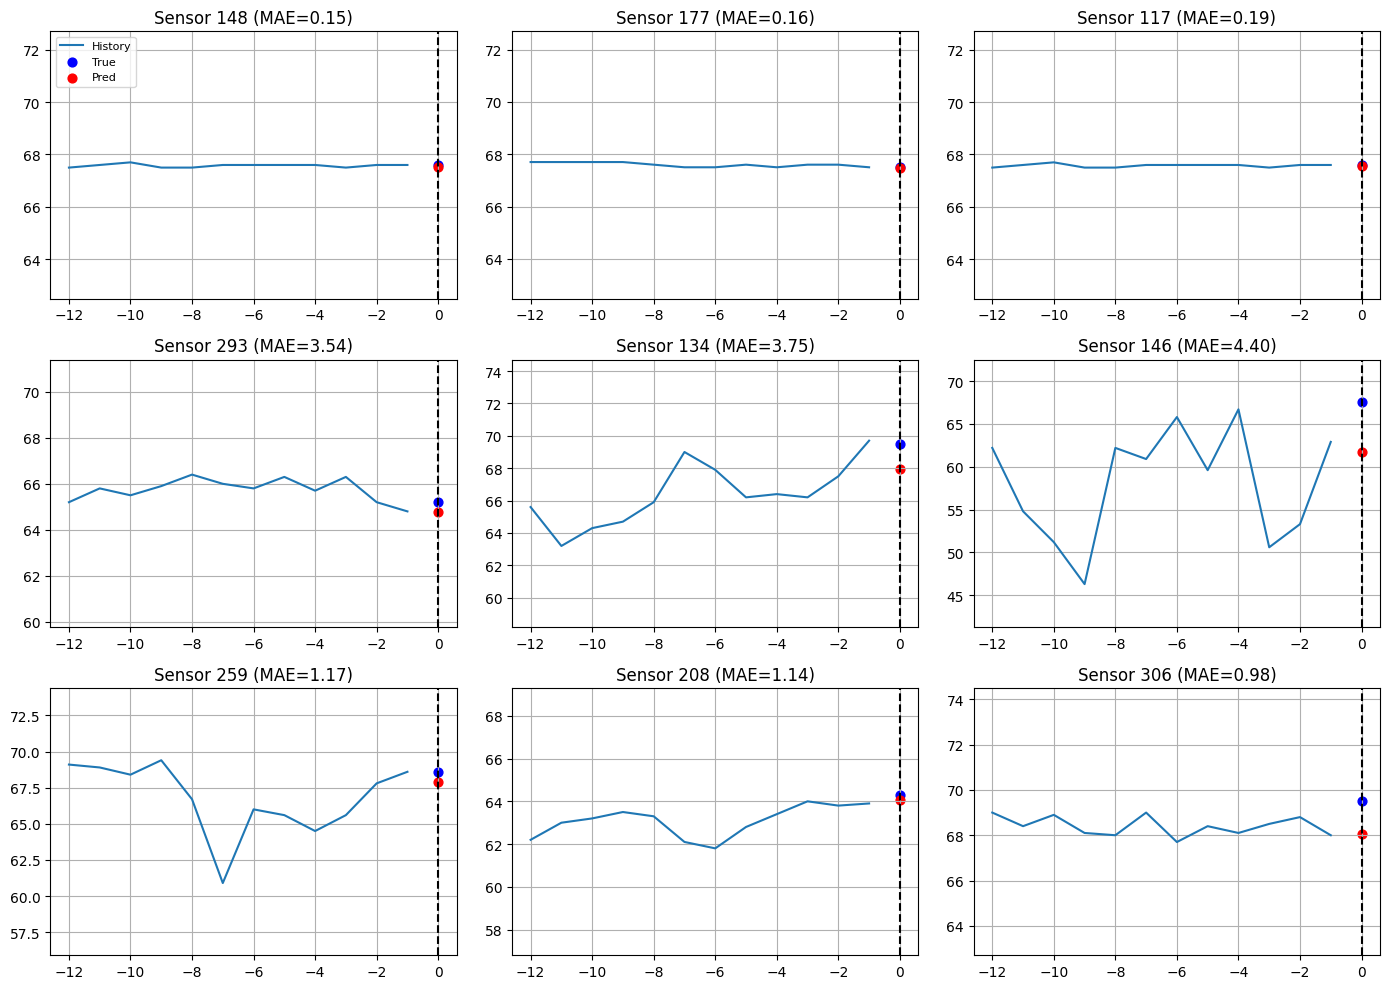

In [26]:
# 15. DCRNN – 3×3 grid: best, worst, and random sensors
# -----------------------------------------------------

import math

# pick 3 best, 3 worst, 3 random
N_sensors = mae_per_sensor.shape[0]

best_3   = np.argsort(mae_per_sensor)[:3]
worst_3  = np.argsort(mae_per_sensor)[-3:]
random_3 = np.random.choice(N_sensors, 3, replace=False)

sensor_indices = list(best_3) + list(worst_3) + list(random_3)
print("Best sensors:", best_3)
print("Worst sensors:", worst_3)
print("Random sensors:", random_3)

cols = 3
rows = 3

# Use last test window
example_idx = X_test.shape[0] - 1
X_example = X_test[example_idx:example_idx+1]  # [1, seq_len, N, 1]
Y_example = Y_test[example_idx:example_idx+1]  # [1, 1,      N, 1]

model.eval()
with torch.no_grad():
    X_torch = torch.from_numpy(X_example).float().to(device)
    pred_full = model(X_torch).cpu().numpy()   # [1, 1, N, 1]

plt.figure(figsize=(14, 10))

for i, sensor_index in enumerate(sensor_indices):
    history_norm     = X_example[0, :, sensor_index, 0]
    true_future_norm = Y_example[0, 0, sensor_index, 0]
    pred_future_norm = pred_full[0, 0, sensor_index, 0]

    mean = float(train_mean[sensor_index])
    std  = float(train_std[sensor_index])

    history     = history_norm * (std + 1e-8) + mean
    true_future = true_future_norm * (std + 1e-8) + mean
    pred_future = pred_future_norm * (std + 1e-8) + mean

    hist_x   = list(range(-len(history), 0))
    future_x = [0]

    ax = plt.subplot(rows, cols, i + 1)
    ax.plot(hist_x, history, label="History", linewidth=1.5)
    ax.scatter(future_x, [true_future], s=40, label="True", color="blue")
    ax.scatter(future_x, [pred_future], s=40, label="Pred", color="red")

    ax.axvline(0, color="k", linestyle="--")
    ax.set_title(f"Sensor {sensor_index} (MAE={mae_per_sensor[sensor_index]:.2f})")
    ax.grid(True)

    # unify y-limits a bit locally for each plot
    ymin = min(history.min(), true_future, pred_future) - 5
    ymax = max(history.max(), true_future, pred_future) + 5
    ax.set_ylim([ymin, ymax])

    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()